<a href="https://colab.research.google.com/github/cyuancheng/NLP_Yelp_review/blob/master/NLP_2_yelp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Natural Language Processing and Sentiment Analysis for Yelp##

Explore Starbucks review in New York City (Rockefeller Center )

In [0]:
import pandas as pd
import numpy as np
import requests
import spacy #use NLP functions
from spacy import displacy
from textblob import TextBlob
import re
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.sentiment.vader import SentimentIntensityAnalyzer

import folium
import warnings
warnings.filterwarnings("ignore")

In [53]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'School_of_AI/'

Mounted at /content/gdrive


###1. Data pre-process and cleaning###
Get data from Yelp API
(50 Starbucks stores near Rockefeller Center in NYC)

In [0]:
#get yelp api (https://www.yelp.com/developers)

client_id = 'fl6Gc_WOT5VLrae0o6fc7w' 
key = 'kArR8ttjf4JdZDtC27-InwcgepdkWrtTcSfaHKwf_JMtQY0LvXgfaG3lmUA3F2oCCp-KUa-W8tPuVXdm8Abwj6N0m0YJniJHVa61rXEFMLuAM11d2IrYSV5NEYGJXHYx'

ENDPOINT = 'https://api.yelp.com/v3/businesses/search'

HEADERS = {'Authorization':'bearer {}'.format(key)}

PARAMETERS = {'term' : 'Starbucks',
              'limit':50,
             'radius':40000, # meter
              'latitude': 40.758862,
              'longitude':-73.978663  # Rockefeller Center
              #'sort_by' :'review_count', 
             #'location':"New York City"
             }

response = requests.get(url = ENDPOINT, params = PARAMETERS, headers = HEADERS)

####Get the data from Yelp API 
look at the first business

In [7]:
data = response.json()
data["businesses"][0]

{'alias': 'starbucks-new-york-273',
 'categories': [{'alias': 'coffee', 'title': 'Coffee & Tea'}],
 'coordinates': {'latitude': 40.758856, 'longitude': -73.978954},
 'display_phone': '(212) 397-7950',
 'distance': 24.51886376624723,
 'id': '5WHpzFh-ZbTBY919PlZPTw',
 'image_url': 'https://s3-media2.fl.yelpcdn.com/bphoto/6f8_MgbQJiloz02QX6Oqxw/o.jpg',
 'is_closed': False,
 'location': {'address1': '30 Rockefeller Plaza',
  'address2': '',
  'address3': '',
  'city': 'New York',
  'country': 'US',
  'display_address': ['30 Rockefeller Plaza', 'New York, NY 10112'],
  'state': 'NY',
  'zip_code': '10112'},
 'name': 'Starbucks',
 'phone': '+12123977950',
 'price': '$$',
 'rating': 3.0,
 'review_count': 72,
 'transactions': [],
 'url': 'https://www.yelp.com/biz/starbucks-new-york-273?adjust_creative=fl6Gc_WOT5VLrae0o6fc7w&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=fl6Gc_WOT5VLrae0o6fc7w'}

Next, we can make a list of the businesses with their id, rating, price, and location

In [0]:
# list of id in businesses with rating
list_buss = []

for item in data['businesses']:
  try:
    list_buss.append([item['id'], item['rating'], item['price'],item['review_count'],\
                      item['coordinates']['latitude'],item['coordinates']['longitude'] ])
  except:
    list_buss.append([item['id'], item['rating'], None, None, None, None])

In [56]:
# convert to pandas format
list_buss = pd.DataFrame(list_buss, columns = ['id','rating','price', 'count', 'latitude','longitude' ])
list_buss.head()

,id,rating,price,count,latitude,longitude
0,5WHpzFh-ZbTBY919PlZPTw,3.0,$$,72.0,40.758856,-73.978954
1,AJR1lIu3RzgC8bgCk2tFog,2.5,$$,30.0,40.758859,-73.978956
2,t8_nm5-yk8ArhZjT3nHxRA,2.5,$$,16.0,40.757802,-73.979602
3,DTRLsTwx0534Iv-0xfXijA,2.5,$$,26.0,40.760364,-73.979084
4,4VwDtb5wOxfaXFOvTp7C6A,2.5,$$,22.0,40.760587,-73.978598


show the business location on the map

In [64]:
locations = list_buss[['latitude', 'longitude']].dropna()
locationlist = locations.values.tolist()  # put all the locations in a list
len(locationlist)

47

In [68]:
map = folium.Map(location=[40.758862, -73.978663], zoom_start=15)

for point in range(0, len(locationlist)):
    folium.Marker(locationlist[point], popup=list_buss['id'][point]).add_to(map)
map

We set the 40000 meter radius on the Yelp API,  but the actural radius is much lower than the 40000 meter in the dense area due to high business density.

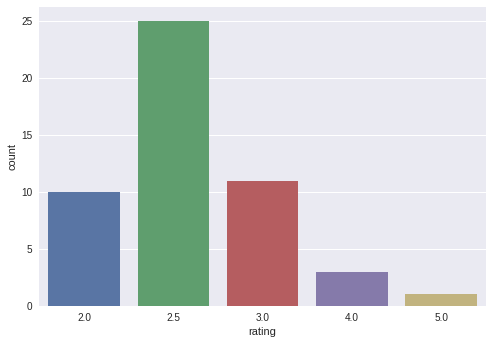

In [69]:
# look at the rating
sns.countplot(x="rating", data=list_buss)

In [70]:
# look at the price
list_buss.groupby('price').count()

,id,rating,count,latitude,longitude
price,,,,,
$,10,10,10,10,10
$$,35,35,35,35,35
$$$,2,2,2,2,2


#### Get review data

In [74]:
data["businesses"][0]['id'] # parse id# for review 

'5WHpzFh-ZbTBY919PlZPTw'

read review of this businesses 

In [0]:
ENDPOINT_reviews = 'https://api.yelp.com/v3/businesses/5WHpzFh-ZbTBY919PlZPTw/reviews'   # id/reviews  
response_reviews = requests.get(url = ENDPOINT_reviews, headers = HEADERS)

Each business has three reviews. Read first review

In [72]:
len(response_reviews.json())

3

In [84]:
response_reviews.json()['reviews'][0]#['user']['id']#['profile_url']

{'id': '3gnJ62usiQh9VDdVPibDAw',
 'rating': 4,
 'text': 'I have been here at 630 am and the staff is always pleasant and well rested. Sometimes there are homeless people sitting in the seats but it may be a way of...',
 'time_created': '2018-11-16 14:36:46',
 'url': 'https://www.yelp.com/biz/starbucks-new-york-273?adjust_creative=fl6Gc_WOT5VLrae0o6fc7w&hrid=3gnJ62usiQh9VDdVPibDAw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=fl6Gc_WOT5VLrae0o6fc7w',
 'user': {'id': 'KVKIvMY5gL5scNgexlENiQ',
  'image_url': 'https://s3-media3.fl.yelpcdn.com/photo/iMhwNj0d6t8ZZJ1sS2i6qg/o.jpg',
  'name': 'Dionne H.',
  'profile_url': 'https://www.yelp.com/user_details?userid=KVKIvMY5gL5scNgexlENiQ'}}

Since each buisness only has three reviews, the rating are not representive the business statistically. So I decide to pull out the rating that directly link to the review.

In [0]:
# collect review
List_review = []
List_rating = []
List_userid = []

for i in range(50):

  try:
    ENDPOINT_reviews = 'https://api.yelp.com/v3/businesses/'+ data["businesses"][i]['id'] +'/reviews'
    response_reviews = requests.get(url = ENDPOINT_reviews, headers = HEADERS)
    
    for ii in range(3):

      a = response_reviews.json()['reviews'][ii]['text']
      List_review .append(a)
      b = response_reviews.json()['reviews'][ii]['rating']
      List_rating.append(b)
      c = response_reviews.json()['reviews'][ii]['user']['id']
      List_userid.append(c)
      
  except:
    pass

In [86]:
d = {'rate': List_rating, 'review': List_review, 'user_id' : List_userid}
df_total = pd.DataFrame(data=d)
df_total.head()

,rate,review,user_id
0,4,I have been here at 630 am and the staff is al...,KVKIvMY5gL5scNgexlENiQ
1,2,"Horrible experience this morning ,app orders s...",Xx4lFM_a8mMsfnzJpsN4Zw
2,3,"Can't say I'm a ""regular"" at Starbucks, but I ...",vmWuNyhSeqeKsLvRtOnYQQ
3,3,I arrived extremely early in NY so I decided t...,L261dYh3HYs28hnYs23yIQ
4,3,"When I was younger, I used to play a game with...",HQ1kFlb7JO8nr-LZwbfEdA


In [0]:
#df_total['review_len'] = df_total['review'].astype(str).apply(len)
df_total['word_count'] = df_total['review'].apply(lambda x: len(str(x).split()))
df_total['Polarity'] = [TextBlob(x).sentiment[0] for x in df_total['review'] ]
df_total['Subjectivity'] = [TextBlob(x).sentiment[1] for x in df_total['review'] ]

In [95]:
df_total.head()

,rate,review,user_id,word_count,Polarity,Subjectivity
0,4,I have been here at 630 am and the staff is al...,KVKIvMY5gL5scNgexlENiQ,32,0.733333,0.966667
1,2,"Horrible experience this morning ,app orders s...",Xx4lFM_a8mMsfnzJpsN4Zw,28,-0.266667,0.700000
2,3,"Can't say I'm a ""regular"" at Starbucks, but I ...",vmWuNyhSeqeKsLvRtOnYQQ,27,0.250000,0.538462
3,3,I arrived extremely early in NY so I decided t...,L261dYh3HYs28hnYs23yIQ,29,0.100000,0.300000
4,3,"When I was younger, I used to play a game with...",HQ1kFlb7JO8nr-LZwbfEdA,28,-0.133333,0.300000


In [0]:
#save file to Google Drive
df_total.to_csv(base_dir + 'export_review_rate.csv', index = None, header=True) #Don't forget to add '.csv' at the end of the path


In [98]:
df_total[df_total['user_id']=="38dPWgd8DRM-I5x4Qr6Fsw"]

,rate,review,user_id,word_count,Polarity,Subjectivity
44,3,"As mentioned below, the service here is lackin...",38dPWgd8DRM-I5x4Qr6Fsw,29,-0.146667,0.640000
134,4,Pretty good Bux for sure. Some good things abo...,38dPWgd8DRM-I5x4Qr6Fsw,27,0.303827,0.631066


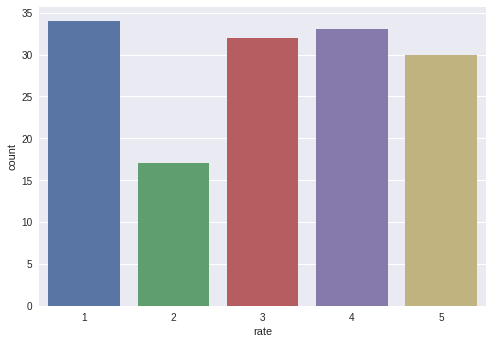

In [23]:
sns.countplot(x="rate", data=df_total)

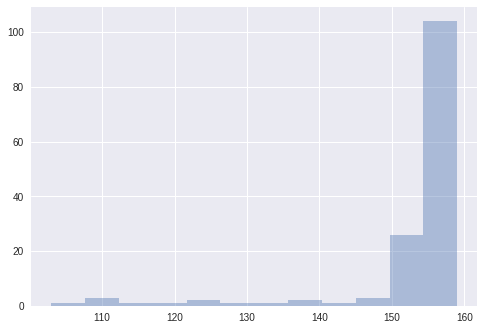

In [26]:
#sns.distplot(x="review_len", data=df_total) 
sns.distplot(df_total["review_len"].values,bins=12,kde=False) 

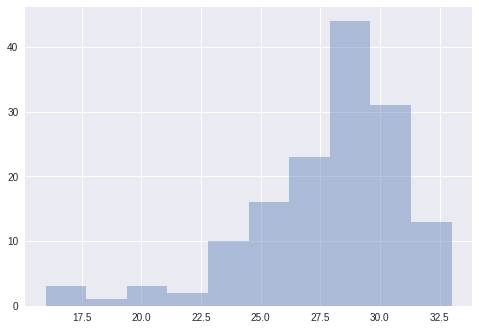

In [33]:
sns.distplot(df_total["word_count"].values,bins=10,kde=False) 

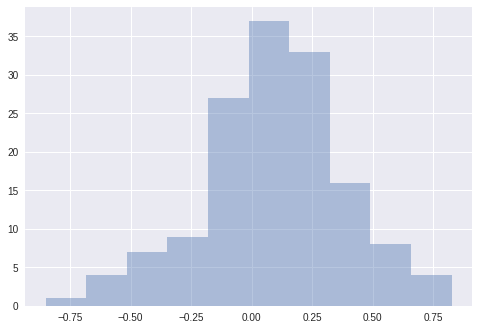

In [31]:
sns.distplot(df_total["Polarity"].values,bins=10,kde=False)

Howis the review rate correlated to the polarity?

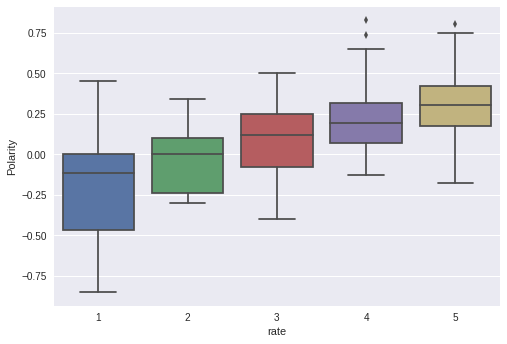

In [35]:
sns.boxplot(x="rate", y="Polarity", data=df_total)

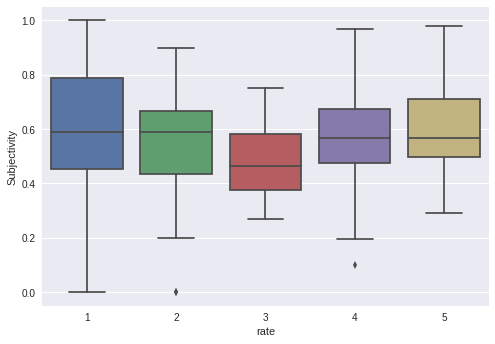

In [36]:
sns.boxplot(x="rate", y="Subjectivity", data=df_total)

Topic Modeling with LSA

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE
from collections import Counter

In [0]:
reindexed_data = df_total['review']
tfidf_vectorizer = TfidfVectorizer(stop_words='english', use_idf=True, smooth_idf=True)
reindexed_data = reindexed_data.values
document_term_matrix = tfidf_vectorizer.fit_transform(reindexed_data)

In [0]:
n_topics = 6
lsa_model = TruncatedSVD(n_components=n_topics)
lsa_topic_matrix = lsa_model.fit_transform(document_term_matrix)

In [0]:
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [0]:
lsa_keys = get_keys(lsa_topic_matrix)
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)

In [0]:
def get_top_n_words(n, keys, document_term_matrix, tfidf_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = tfidf_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

In [50]:
top_n_words_lsa = get_top_n_words(3, lsa_keys, document_term_matrix, tfidf_vectorizer)

for i in range(len(top_n_words_lsa)):
    print("Topic {}: ".format(i+1), top_n_words_lsa[i])

Topic 1:  starbucks service location
Topic 2:  order minutes got
Topic 3:  location busy seating
Topic 4:  staff morning small
Topic 5:  times line located
Topic 6:  best like makes


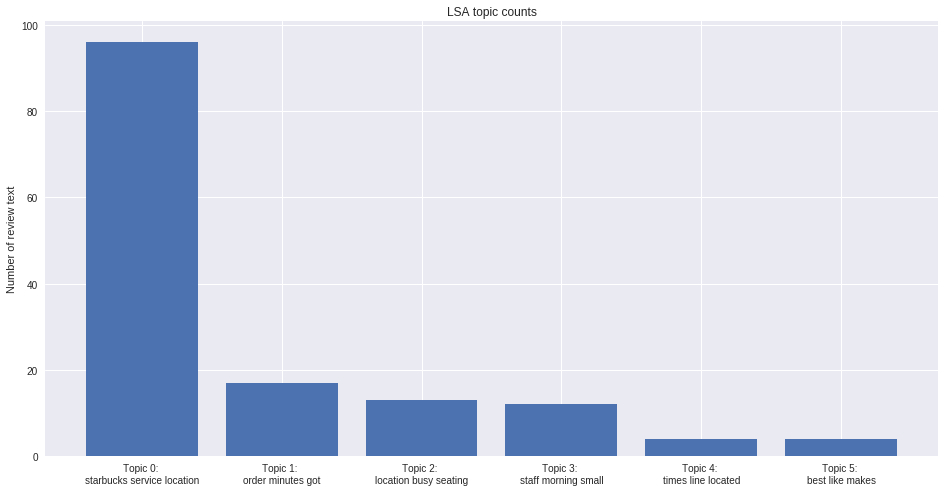

In [51]:
top_3_words = get_top_n_words(3, lsa_keys, document_term_matrix, tfidf_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lsa_categories]

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(lsa_categories, lsa_counts);
ax.set_xticks(lsa_categories);
ax.set_xticklabels(labels);
ax.set_ylabel('Number of review text');
ax.set_title('LSA topic counts');
plt.show();